In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json
import shutil
import healpy

from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess

%matplotlib inline

In [2]:
initial_mtl_file = "targets/subset_dr8_mtl_dark_gray_NGC.fits"
targets = Table.read(initial_mtl_file)

In [3]:
pixweight_file = "/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits"
pixweight, header = fits.getdata(pixweight_file, 'PIXWEIGHTS', header=True)
hpxnside = header['HPXNSIDE']

In [4]:
Table(pixweight)

HPXPIXEL,FRACAREA,STARDENS,EBV,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,ELG,LRG,QSO,BGS_ANY,MWS_ANY,ALL,STD_FAINT,STD_BRIGHT,LRG_1PASS,LRG_2PASS,BGS_FAINT,BGS_BRIGHT,BGS_WISE,MWS_BROAD,MWS_MAIN_RED,MWS_MAIN_BLUE,MWS_WD,MWS_NEARBY
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,0.980634,457.528,0.0892718,2780.19,2013.2,298.442,1669.17,1032.87,138.744,2.58075,0.682658,1.35885,1.10376,1.02002,2287.64,705.355,419.4,1334.46,915.055,5528.46,57.1909,19.0637,400.337,305.018,552.846,781.61,0.0,495.655,95.3182,324.082,0.0,0.0
1,0.999698,495.655,0.10813,2841.96,2065.16,301.767,1717.01,1058.98,139.818,2.61975,0.679457,1.3676,1.10575,1.0115,2459.21,629.1,305.018,1124.76,972.246,5242.5,57.1909,0.0,381.273,247.827,381.273,705.355,38.1273,419.4,114.382,438.464,0.0,0.0
2,0.998935,324.082,0.0835982,2844.06,2103.71,275.169,1672.75,1069.77,133.88,2.57428,0.676512,1.31849,1.11161,1.07002,2421.08,419.4,209.7,2992.99,934.119,6767.6,95.3182,57.1909,209.7,209.7,895.992,2077.94,19.0637,381.273,95.3182,457.528,0.0,0.0
3,1.03249,305.018,0.0903878,2677.02,2040.33,265.27,1526.29,1064.84,127.024,2.57899,0.679367,1.34237,1.12885,1.06931,2459.21,552.846,228.764,1315.39,934.119,5375.95,38.1273,19.0637,381.273,171.573,571.909,705.355,38.1273,457.528,133.446,343.146,0.0,0.0
4,1.01342,590.973,0.106728,2472.99,1645.86,251.791,1581.52,852.609,116.365,2.57793,0.662332,1.43958,1.1395,1.01186,2192.32,781.61,152.509,1048.5,972.246,5013.74,57.1909,0.0,533.782,247.827,381.273,667.228,0.0,590.973,57.1909,324.082,0.0,19.0637
5,0.996648,514.719,0.0939747,1766.92,939.107,153.506,1217.75,517.151,69.7392,2.4718,0.63304,1.59763,1.21069,1.00315,2535.47,705.355,324.082,1048.5,819.737,5166.25,19.0637,38.1273,590.973,114.382,533.782,457.528,57.1909,362.209,152.509,305.018,0.0,0.0
6,0.998935,362.209,0.0946961,2892.07,1884.51,282.814,1714.08,1007.95,135.987,2.62698,0.681031,1.36397,1.17601,1.05707,2649.85,476.591,438.464,1220.07,1010.37,5547.52,57.1909,38.1273,266.891,209.7,476.591,648.164,95.3182,514.719,95.3182,400.337,0.0,0.0
7,1.02562,285.955,0.092858,3026.93,1582.52,273.611,1752.53,879.815,128.345,2.49147,0.640421,1.36608,1.23789,1.05517,2554.53,610.037,247.827,1162.88,762.546,5223.44,76.2546,38.1273,552.846,57.1909,362.209,800.673,0.0,362.209,190.636,209.7,0.0,0.0
8,1.02867,552.846,0.0812066,2454.4,1723.12,226.535,1451.63,897.152,111.306,2.57366,0.681933,1.34294,1.12922,1.08971,2211.38,266.891,285.955,1753.86,953.182,5375.95,0.0,0.0,228.764,38.1273,552.846,1201.01,0.0,457.528,171.573,305.018,19.0637,38.1273


In [6]:
pixelarea = healpy.pixelfunc.nside2pixarea(hpxnside, degrees=True)
print(pixelarea) #pixel area from the input catalogs

0.0524558528257


In [7]:
theta_w, phi_w = healpy.pix2ang(hpxnside, pixweight['HPXPIXEL'], nest=True)

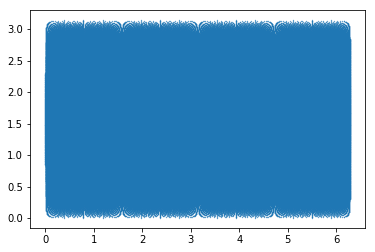

In [8]:
plt.scatter(phi_w, theta_w, s=0.1)

In [9]:
hpxnside_sample = 64 # pixel area to select
npix_sample = healpy.nside2npix(hpxnside_sample)
print(npix_sample)
pixnumber_sample = healpy.ang2pix(hpxnside_sample, theta_w, phi_w, nest=True)

subpixels = {} # store the pixels at the resolution in the input target catalog that are included within the pixels at the new resolution.
for i in range(npix_sample):
    ii_sample = pixnumber_sample==i
    subpixels[i] =  healpy.ang2pix(hpxnside, theta_w[ii_sample], phi_w[ii_sample], nest=True)

49152


In [10]:
# redefine the covered area for the new pixels from the higher resolution FRACAREA
covered_area = np.ones(npix_sample)
for i in range(npix_sample):
    sum_weight = np.sum(pixweight['FRACAREA'][subpixels[i]])
    if sum_weight>0.0:
        covered_area[i] = np.sum(pixweight['FRACAREA'][subpixels[i]]**2)/np.sum(pixweight['FRACAREA'][subpixels[i]])
    else:
        covered_area[i] = 0.0

In [11]:
theta_s, phi_s = healpy.pix2ang(hpxnside_sample, np.arange(npix_sample), nest=True)

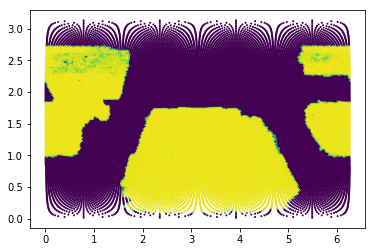

In [12]:
plt.scatter(phi_s, theta_s, c=covered_area, s=1.0)

In [13]:
pixelarea_sample = healpy.pixelfunc.nside2pixarea(hpxnside_sample, degrees=True)
n_lya_qso_in_pixel = np.int_(covered_area * 50 * pixelarea_sample)
print(np.sum(n_lya_qso_in_pixel))

975988


In [14]:
targets_phi = np.deg2rad(targets['RA'])
targets_theta = np.deg2rad(90.0-targets['DEC'])

In [15]:
r = np.random.random(len(targets_phi))
rr = r <0.001

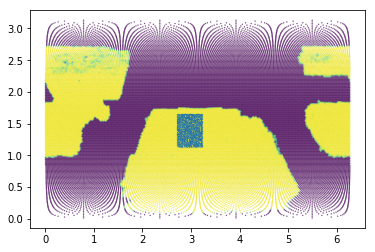

In [16]:
plt.scatter(phi_s, theta_s, c=covered_area, s=0.1)
plt.scatter(targets_phi[rr], targets_theta[rr], s=0.01)

In [17]:
pixnumber_targets = healpy.ang2pix(hpxnside_sample, targets_theta, targets_phi, nest=True)

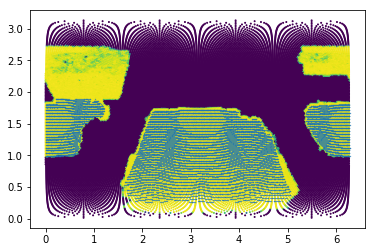

In [18]:
tiles = desimodel.io.load_tiles()
plt.scatter(phi_s, theta_s, c=covered_area, s=1.0)
plt.scatter(np.deg2rad(tiles['RA']), np.deg2rad(90-tiles['DEC']), s=0.1)

In [19]:
is_qso = (targets['DESI_TARGET'] & desi_mask.QSO)!=0
print(np.count_nonzero(is_qso))
print(np.sum(n_lya_qso_in_pixel[list(set(pixnumber_targets))]))

246913
47393


In [20]:
pixnumber_target_list = list(set(pixnumber_targets)) # list of pixelsIDs covered by the targets in the new resolution

In [21]:
n_qso_per_pixel_targets = np.zeros(len(pixnumber_target_list))
for i in range(len(pixnumber_target_list)):
    ii_targets = is_qso & (pixnumber_targets==pixnumber_target_list[i])
    n_qso_per_pixel_targets[i] = np.count_nonzero(ii_targets)

In [23]:
n_lya_desired_pixel_targets = np.random.poisson(n_lya_qso_in_pixel[pixnumber_target_list])

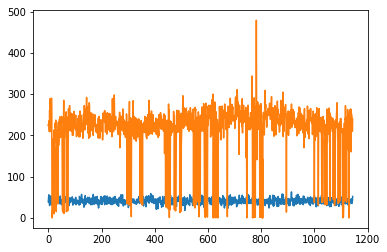

In [24]:
plt.plot(n_lya_desired_pixel_targets)
plt.plot(n_qso_per_pixel_targets)

In [25]:
is_lya_qso = np.repeat(False, len(targets))
n_targets = len(targets)
target_ids = np.arange(n_targets)

for i in range(len(pixnumber_target_list)):
    ii_targets = is_qso & (pixnumber_targets==pixnumber_target_list[i])
    n_qso_in_pixel = np.count_nonzero(ii_targets)
    n_lya_desired = np.random.poisson(n_qso_in_pixel)
    if n_lya_desired >= n_qso_in_pixel:
        is_lya_qso[ii_targets] = True
    else:
        print(len(target_ids[ii_targets]), n_lya_desired)
        ii_lya_qso = np.random.choice(target_ids[ii_targets], n_lya_desired, replace=False)
        is_lya_qso[ii_lya_qso] = True

225 216
224 210
209 203
261 238
289 287
233 222
219 205
209 198
290 264
249 236
11 10
21 18
192 191
10 8
181 172
187 178
218 212
237 231
216 215
232 206
223 194
245 238
244 236
185 157
197 180
285 284
192 182
195 190
241 227
241 227
21 16
196 193
200 195
17 12
176 166
264 232
235 196
272 257
229 223
254 237
210 195
231 222
200 193
252 239
226 220
218 206
230 226
258 253
240 228
242 208
221 202
219 208
200 197
240 233
216 178
196 195
238 237
233 207
259 254
197 181
237 217
237 216
209 202
227 225
251 242
248 244
218 213
272 254
213 211
226 219
273 265
292 276
270 257
279 273
270 258
249 235
218 217
217 209
223 200
200 155
242 235
227 226
222 205
250 244
231 214
206 198
214 207
194 186
194 193
244 241
222 194
194 189
194 187
232 223
238 236
213 205
189 183
234 220
208 196
253 235
226 212
243 232
255 248
214 210
246 243
248 238
209 194
241 214
243 241
244 243
289 277
234 210
252 236
209 195
298 278
251 237
214 201
226 221
246 238
225 205
234 230
233 210
216 205
170 158
200 197
247 246
245

In [26]:
print(np.count_nonzero(is_lya_qso))

240877


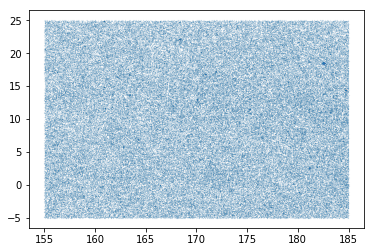

In [29]:
plt.scatter(targets['RA'][is_lya_qso], targets['DEC'][is_lya_qso], s=0.001)